# Session 1 - Linear Regression

## Contents

- [Simple Linear Regression](#Simple-Linear-Regression)
- [Multiple Linear Regression](#Multiple-Linear-Regression)
- [Other Considerations in the Regression Model](#Other-Considerations-in-the-Regression-Model)

## Labs

- [Linear Regression](#Lab-1:-Linear-Regression)

In [1]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from numpy.linalg import inv
from numpy.random import normal as rnorm
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

You can inspect all the available global parameter options [here](https://matplotlib.org/3.3.2/tutorials/introductory/customizing.html).

## Simple Linear Regression

First, let's load the Advertising dataset. It contains information on displays sales (in thousands of units) for a particular product and a list of advertising budgets (in thousands of dollars) for TV, radio, and newspaper media.

We open the dataset using the `pandas` library which is **the** library for datasets in Python.`

In [3]:
# Advertisement spending data
advertising = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])

Let's have a look at the content. We can have a glance at the first rows by using the function `head`.

In [4]:
# Preview of the data
advertising.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


We can have a general overview of the dataset using the function `info`.

In [5]:
# Overview of all variables
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


We can have more information on the single varaibles using the function `decribe`.

In [6]:
# Summary of all variables
advertising.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


If you just want to call a variable in `pandas`, you have to options:
1. use squared brackets as if the varaible was a component of a dictionary
2. use or dot subscripts as if the variable was a function of the data
3. use the `loc` function (best practice)

In [7]:
# 1. Brackets
advertising['TV']

0      230.1
1       44.5
2       17.2
3      151.5
4      180.8
       ...  
195     38.2
196     94.2
197    177.0
198    283.6
199    232.1
Name: TV, Length: 200, dtype: float64

In [8]:
advertising.TV

0      230.1
1       44.5
2       17.2
3      151.5
4      180.8
       ...  
195     38.2
196     94.2
197    177.0
198    283.6
199    232.1
Name: TV, Length: 200, dtype: float64

In [9]:
# The loc function
advertising.loc[:,'TV']

0      230.1
1       44.5
2       17.2
3      151.5
4      180.8
       ...  
195     38.2
196     94.2
197    177.0
198    283.6
199    232.1
Name: TV, Length: 200, dtype: float64

Note that the `loc` function is more powerful and is generally used to subset lines and columns.

In [10]:
# Select multiple columns and subset of rows
advertising.loc[0:5,['Sales','TV']]

,Sales,TV
0,22.1,230.1
1,10.4,44.5
2,9.3,17.2
3,18.5,151.5
4,12.9,180.8
5,7.2,8.7


Suppose we are interested in the (linear) relationship between sales and tv advertisement.

$$
sales ≈ \beta_0 + \beta_1 TV.
$$

How are the two two variables related? Visual inspection: scatterplot.

We are going to use a shortcut: the library `seaborn` is a great library for data visualization that allows us to directly print a "best fit" line into a scatterplot.

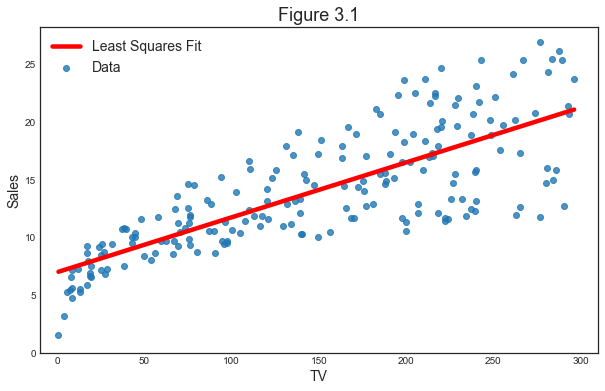

In [11]:
# Figure 3.1 - Least squares fit
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 3.1');

# Plot scatter and best fit line
sns.regplot(x=advertising.TV, y=advertising.Sales, ax=ax, order=1, ci=None, line_kws={'color':'r'})
ax.set_xlim(-10,310); ax.set_ylim(ymin=0)
ax.legend(['Least Squares Fit','Data']);

### Estimating the Coefficients

How do we estimate the best fit line? Minimize the Residual Sum of Squares (RSS).

First, suppose we have a dataset $\mathcal D = \{x_i, y_i\}_{i=1}^N$. We define the prediction of $y$ based on $X$ as

$$
\hat y_i = \hat \beta X_i
$$

The residuals are the unexplained component of $y$

$$
e_i = y_i - \hat y_i
$$

Our objective function (to be minimized) is the Resdual Sum of Squares (RSS):

$$
RSS := \sum_{n=1}^N e_i^2
$$

And the OLS coefficient is defined as its minimizer:

$$
\hat \beta_{OLS} := \arg\min_{\beta} \sum_{n=1}^N e_i^2 = \arg\min_{\beta} \sum_{n=1}^N (y_i - X_i \beta)^2
$$

Let's use the `sklearn` library to fit a linear regression model of *Sales* on *TV* advertisement.

In [12]:
# Define X and y
X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales.values

# Fit linear regressions
reg = LinearRegression().fit(X,y)
print(reg.intercept_)
print(reg.coef_)

7.032593549127695
[0.04753664]


We can visualize the residuals as the vertical distances between the data and the prediction line. The objective function RSS is the sum of the squares of the lengths of vertical lines.

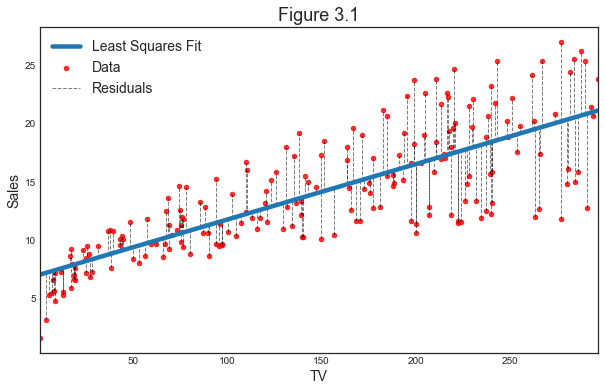

In [13]:
# Compute predicted values
y_hat = reg.predict(X)

# Figure 3.1
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 3.1');

# Add residuals
sns.regplot(x=advertising.TV, y=advertising.Sales, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':20})
ax.vlines(X, np.minimum(y,y_hat), np.maximum(y,y_hat), linestyle='--', color='k', alpha=0.5, linewidth=1)
plt.legend(['Least Squares Fit','Data','Residuals']);

The closed form solution in matrix algebra is
$$
\hat \beta_{OLS} = (X'X)^{-1}(X'y)
$$

Python has a series of shortcuts to make the syntax less verbose. However, we still need to import the `inv` function from `numpy`. In Matlab it would be `(X'*X)^{-1}*(X'*y)`, almost literal.

In [14]:
# Compute OLS coefficient with matrix algebra
beta = inv(X.T @ X) @ X.T @ y

print(beta)

[0.08324961]


Why is the result different?

We are missing one coefficient: the intercept. Our regression now looks like this

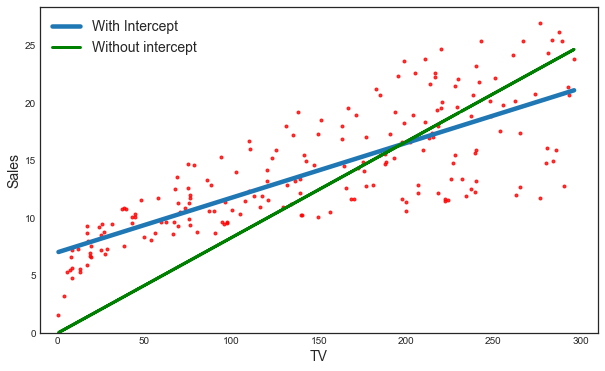

In [15]:
fig, ax = plt.subplots(1,1)

# Add new line on the previous plot
sns.regplot(x=advertising.TV, y=advertising.Sales, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':9})
ax.plot(X, beta*X, color='g')
plt.xlim(-10,310); plt.ylim(ymin=0);
ax.legend(['With Intercept', 'Without intercept']);

How do we insert an intercept using matrix algebra? We add a column of ones.

$$
X_1 = [\boldsymbol{1}, X]
$$

In [16]:
# How to insert intercept? Add constant: column of ones
one = np.ones(np.shape(X))
X1 = np.concatenate([one,X],axis=1)

print(np.shape(X1))

(200, 2)


Now we compute again the coefficients as before.

$$
\hat \beta_{OLS} = (X_1'X_1)^{-1}(X_1'y)
$$

In [17]:
# Compute beta OLS with intercept
beta_OLS = inv(X1.T @ X1) @ X1.T @ y

print(beta_OLS)

[7.03259355 0.04753664]


Now we have indeed obtained the same exact coefficients.

What does minimizing the Residual Sum of Squares means in practice? How does the objective function looks like?

In [18]:
from sklearn.preprocessing import scale

# First, scale the data
X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.Sales
regr = LinearRegression().fit(X,y)

# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

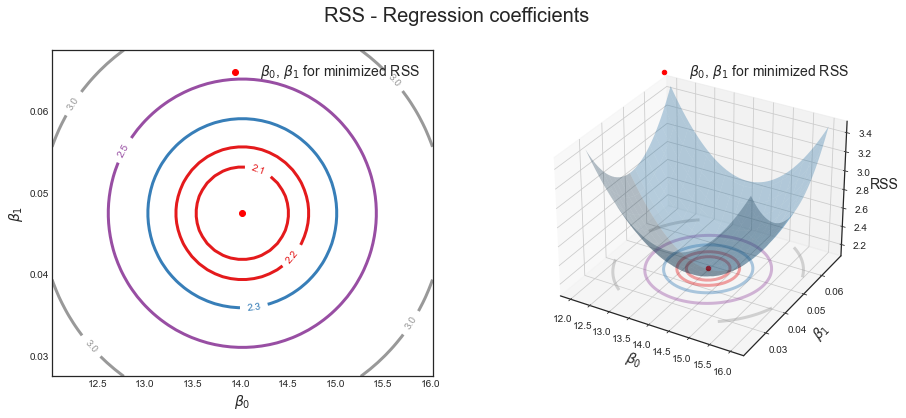

In [19]:
# Figure 3.2 - Regression coefficients - RSS
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Assessing the Accuracy of the Coefficient Estimates

How accurate is our regression fit? Suppose we were drawing different (small) samples from the same data generating process, for example

$$
y_i = 2 + 3x_i + \varepsilon_i
$$

where $x_i \sim N(0,1)$ and $\varepsilon \sim N(0,3)$.

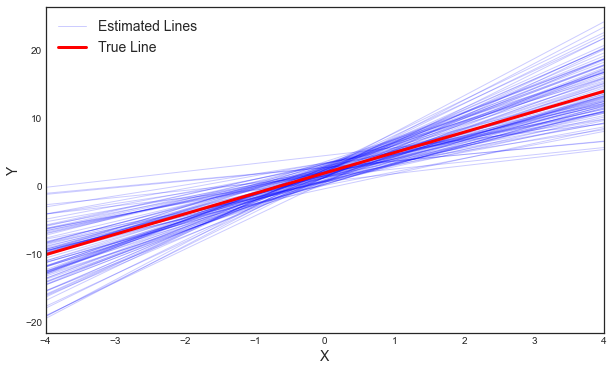

In [20]:
fig, ax = plt.subplots(1,1)

# Init
N = 30;
K = 100;
beta_hat = np.zeros((2,K))
x = np.linspace(-4,4,N)

# Set seed
np.random.seed(1)

# K simulations
for i in range(K):
    # Simulate data
    x1 = np.random.normal(0,1,N).reshape([-1,1])
    X = np.concatenate([np.ones(np.shape(x1)), x1], axis=1)
    epsilon = np.random.normal(0,5,N)
    beta0 = [2,3]
    y = X @ beta0 + epsilon

    # Estimate coefficients
    beta_hat[:,i] = inv(X.T @ X) @ X.T @ y

    # Plot line
    ax.plot(x, beta_hat[0,i] + x*beta_hat[1,i], color='blue', alpha=0.2, linewidth=1)
    if i==K-1:
        ax.plot(x, beta_hat[0,i] + x*beta_hat[1,i], color='blue', alpha=0.2, linewidth=1, label='Estimated Lines')
    
# Plot true line
ax.plot(x, 2 + 3*x, color='red', linewidth=3, label='True Line');
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.legend();
ax.set_xlim(-4,4);

The `regplot` command lets us automatically draw confidence intervals. Let's draw the last simulated dataset with conficence intervals.

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 30 and the array at index 1 has size 400

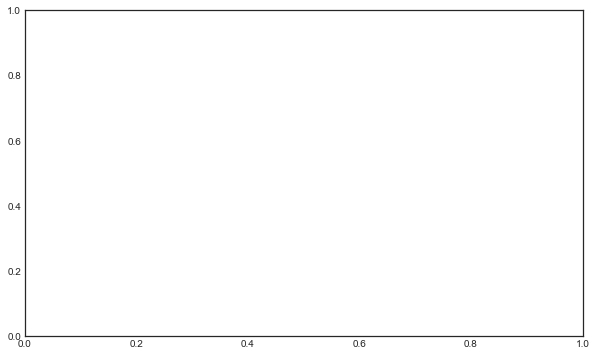

In [93]:
fig, ax = plt.subplots(1,1)

# Plot last simulation scatterplot with confidence interval
sns.regplot(x=x1, y=y, ax=ax, order=1, scatter_kws={'color':'r', 's':10});
ax.set_xlabel('X'); ax.set_ylabel('Y'); 
ax.legend(['Best fit','Data', 'Confidence Intervals']);

As we can see, depending on the sample, we get a different estimate of the linear relationship between $x$ and $y$. However, there estimates are on average correct. Indeed, we can visualize their distribution.

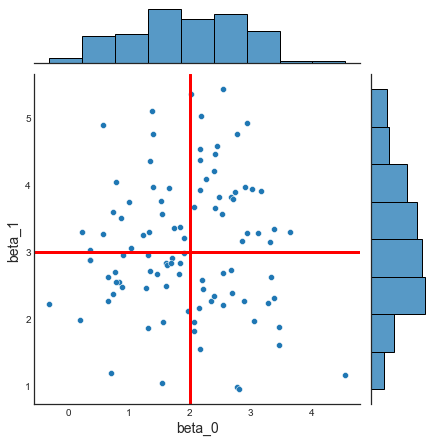

In [22]:
# Plot distribution of coefficients
plot = sns.jointplot(x=beta_hat[0,:], y=beta_hat[1,:], edgecolor="white");
plot.ax_joint.axvline(x=2, color='red');
plot.ax_joint.axhline(y=3, color='red');
plot.set_axis_labels('beta_0', 'beta_1');

How do we compute confidence intervals by hand?

$$
Var(\hat \beta_{OLS}) = \sigma^2 (X'X)^{-1}
$$

where $\sigma^2 = Var(\varepsilon)$. Since we do not know $Var(\varepsilon)$, we estimate it as $Var(e)$.

$$
\hat Var(\hat \beta_{OLS}) = \hat \sigma^2 (X'X)^{-1}
$$

If we assume the standard errors are normally distributed (or we apply the Central Limit Theorem, assuming $n \to \infty$), a 95% confidence interval for the OLS coefficient takes the form

$$
CI(\hat \beta_{OLS}) = \Big[ \hat \beta_{OLS} - 1.96 \times \hat SE(\hat \beta_{OLS}) \ , \ \hat \beta_{OLS} + 1.96 \times \hat SE(\hat \beta_{OLS}) \Big]
$$

where $\hat SE(\hat \beta_{OLS}) = \sqrt{\hat Var(\hat \beta_{OLS})}$.

In [23]:
# Import again X and y from example above
X = advertising.TV.values.reshape(-1,1)
X1 = np.concatenate([np.ones(np.shape(X)), X], axis=1)
y = advertising.Sales.values

# Compute residual variance
X_hat = X1 @ beta_OLS
e = y - X_hat
sigma_hat = np.var(e)
var_beta_OLS = sigma_hat * inv(X1.T @ X1)

# Take elements on the diagonal and square them
std_beta_OLS = [var_beta_OLS[0,0]**.5, var_beta_OLS[1,1]**.5]

print(std_beta_OLS)

[0.4555479737400674, 0.0026771203500466564]


The `statsmodels` library allows us to produce nice tables with parameter estimates and standard errors.

In [24]:
# Table 3.1 & 3.2
est = sm.OLS.from_formula('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


### Assessing the Accuracy of the Model

What metrics can we use to assess whether the model is a good model, in terms of capturing the relationship between the variables?

First, we can compute our objective function: the Residual Sum of Squares (*RSS*). Lower values of our objective function imply that we got a better fit.

In [25]:
# RSS with regression coefficients
RSS = sum(e**2)

print(RSS)

2102.5305831313512


The problem with *RSS* as a metric is that it's hard to compare different regressions since its scale depends on the magnitude of the variables.

One measure of fit that does not depend on the magnitude of the variables is $R^2$: the percentage of our explanatory variable explained by the model

$$
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}
$$

where

$$
TSS = \sum_{i=1}^N (y_i - \bar y)^2
$$

In [26]:
# TSS
TSS = sum( (y-np.mean(y))**2 )

# R2
R2 = 1 - RSS/TSS

print(R2)

0.6118750508500708


Can the $R^2$ metric be negative? When?

## Multiple Linear Regression

What if we have more than one explanatory variable? Spoiler: we already did, but one was a constant.

Let's have a look at the regression of *Sales* on *Radio* and *TV* advertisement expenditure separately.

In [27]:
# Table 3.3 (1)
est = sm.OLS.from_formula('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [28]:
# Table 3.3 (2)
est = sm.OLS.from_formula('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


It seems that both Radio and Newspapers are positively correlated with *Sales*. Why don't we estimate a unique regression with both dependent variables?

### Estimating the Regression Coefficients

Suppose now we enrich our previous model adding all different forms of advertisement:

$$
\text{Sales} = \beta_0 + \beta_1 \text{TV} + \beta_2 \text{Radio} + \beta_3 \text{Newspaper} + \varepsilon
$$

We estimate it using the `statsmodels` `ols` library.

In [29]:
# Table 3.4
est = sm.OLS.from_formula('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


Why now it seems that there is no relationship between Sales and Newspaper while the univariate regression told us the opposite?

Let's explore the correlation between those variables.

In [30]:
# Table 3.5 - Correlation Matrix
advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


Let's try to inspect the relationship visually. Note that now the linear best fit is going to be 3-dimensional. In order to make it visually accessible, we consider only on *TV* and *Radio* advertisement expediture as dependent variables. The best fit will be a plane instead of a line.

In [31]:
# Fit regression
est = sm.OLS.from_formula('Sales ~ Radio + TV', advertising).fit()
print(est.params)

Intercept    2.921100
Radio        0.187994
TV           0.045755
dtype: float64


In [32]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(est.params[0] + B1[i,j]*est.params[1] + B2[i,j]*est.params[2])

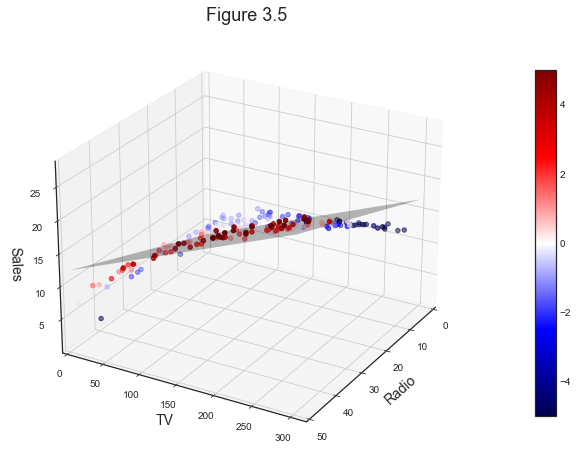

In [33]:
# Figure 3.5 - Multiple Linear Regression
fig = plt.figure()
ax = axes3d.Axes3D(fig)
ax.set_title('Figure 3.5');


# Plot best fit plane
ax.plot_surface(B1, B2, Z, color='k', alpha=0.3)
points = ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c=e, cmap="seismic", vmin=-5, vmax=5)
plt.colorbar(points, cax=fig.add_axes([0.9, 0.1, 0.03, 0.8]))
ax.set_xlabel('Radio'); ax.set_xlim(0,50)
ax.set_ylabel('TV'); ax.set_ylim(bottom=0)
ax.set_zlabel('Sales');
ax.view_init(25, 30)

### Some Important Questions

How do you check whether the model fit well the data with multiple regressors? `statmodels` and most regression packages automatically outputs more information about the least squares model.

In [34]:
# Measires of fit
est.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,859.6
Date:,"Fri, 30 Oct 2020",Prob (F-statistic):,4.83e-98
Time:,09:55:08,Log-Likelihood:,-386.20
No. Observations:,200,AIC:,778.4
Df Residuals:,197,BIC:,788.3
Df Model:,2,,
Covariance Type:,nonrobust,,


First measure: the **F-test**. The F-test tries to answe the question "*Is There a Relationship Between the Response and Predictors?*"

In particular, it tests the following hypothesis

$$
H_1: \text{is at least one coefficient different from zero?}
$$

against the null hypothesis

$$
H_0: \beta_0 = \beta_1 = ... = 0
$$

This hypothesis test is performed by computing the F-statistic,

$$
F=\frac{(\mathrm{TSS}-\mathrm{RSS}) / p}{\operatorname{RSS} /(n-p-1)}
$$

Let's try to compute it by hand.

In [35]:
# Init
X = advertising[['Radio', 'TV']]
y = advertising.Sales
e = y - est.predict(X)
RSS = np.sum(e**2)
TSS = np.sum((y - np.mean(y))**2)
(n,p) = np.shape(X)

# Compute F
F = ((TSS - RSS)/p) / (RSS/(n-p-1))
print('F = %.4f' % F)

F = 859.6177


A rule of thumb is to reject $H_0$ if $F > 10$.

We can also test that a particular subset of coefficients are equal to zero. In that case, we just substitute the Total Sum of Squares (TSS) with the Residual Sum of Squares under the null. 

$$
F=\frac{(\mathrm{RSS_0}-\mathrm{RSS}) / p}{\operatorname{RSS} /(n-p-1)}
$$

i.e. we perfome the regression under the null hypothesis and we compute

$$
RSS_0 = \sum_{n=1}^N (y_i - X_i \beta)^2 \quad s.t. \quad  H_0
$$

## Other Considerations in the Regression Model

### Qualitative Predictors

What if some variables are qualitative instead of quantitative? Let's change dataset and use the `credit` dataset.

In [36]:
# Credit ratings dataset
credit = pd.read_csv('data/Credit.csv', usecols=list(range(1,12)))

This dataset contains information on credit ratings, i.e. each person is assigned a `Rating` score based on his/her own individual characteristics.

In [37]:
# Summary
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB


As we can see, some variables like `Gender`, `Student` or `Married` are not numeric.

In [38]:
# Look at data
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Let's consider the variable `Student`. From a quick inspection it looks like it's a binary *Yes/No* variable. Let's check by listing all its values.

In [39]:
# What values does the Student variable take?
credit['Student'].unique()

array(['No', 'Yes'], dtype=object)

What happens if you pass a binary varaible to `statsmodel`? It automatically generates a dummy out of it.

In [40]:
# Table 3.7
est = sm.OLS.from_formula('Balance ~ Student', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,480.3694,23.434,20.499,0.000,434.300,526.439
Student[T.Yes],396.4556,74.104,5.350,0.000,250.771,542.140


If a variable takes more than one value, `statsmodel` automatically generates a uniqe dummy for each level (-1).

In [41]:
# Table 3.8
est = sm.OLS.from_formula('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


### Extensions of the Linear Model

#### Relaxing the additive assumption

We have seen that both TV and Radio advertisement are positively associated with Sales. What if there is a synergy? For example it might be that if someone sees an ad *both* on TV and on the radio, s/he is much more likely to buy the product.

Consider the following model

$$
\text{Sales} ≈ \beta_0 + \beta_1 \text{TV} + \beta_2 \text{Radio} + \beta_3 \text{TV} \times \text{Radio}
$$

which can be rewritten as

$$
\text{Sales} ≈ \beta_0 + (\beta_1 + \beta_3 \text{Radio}) \times \text{TV} + \beta_2 \text{Radio}
$$

In [42]:
# Table 3.9 - Interaction Variables
est = sm.OLS.from_formula('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


A positive and significant interaction term indicates a hint of a sinergy effect.

#### Heterogeneous effects

We can do interactions with qualitative variables as well. Conside the credit rating dataset. 

What if `Balance` depends by `Income` differently, depending on whether one is a `Student` or not?

Consider the following model:

$$
\text{Balance} ≈ \beta_0 + \beta_1 \text{Income} + \beta_2 \text{Student} + \beta_3 \text{Income} \times \text{Student}
$$

The last coefficient $\beta_3$ should tell us how much `Balance` increases in `Income` for `Students` with respect to non-Students.

Indeed, we can decompose the regression in the following equivalent way:

$$
\text{Balance} ≈ \beta_0 + \beta_1 \text{Income} + \beta_2 \text{Student} + \beta_3 \text{Income} \times \text{Student}
$$

which can be interpreted in the following way since `Student` is a binary variable
1. If the person is *not* a student
$$
\text{Balance} ≈ \beta_0 + \beta_1 \text{Income}
$$

2. If the person is a student
$$
\text{Balance} ≈ (\beta_0 + \beta_2) + (\beta_1 + \beta_3 ) \text{Income}
$$

We are allowing not only for a different intercept for `Students`, $\beta_0 \to \beta_0 + \beta_2$,  but also for a different impact of `Income`, $\beta_1 \to \beta_1 + \beta_3$.

In [43]:
# Divide data into students and non-students
x_student = credit.loc[credit.Student=='Yes','Income']
y_student = credit.loc[credit.Student=='Yes','Balance']
x_nonstudent = credit.loc[credit.Student=='No','Income']
y_nonstudent = credit.loc[credit.Student=='No','Balance']

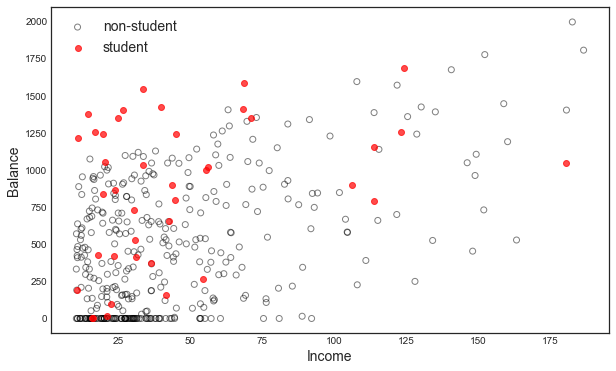

In [44]:
fig, ax = plt.subplots(1,1)

# Relationship betweeen income and balance for students and non-students
ax.scatter(x=x_nonstudent, y=y_nonstudent, facecolors='None', edgecolors='k', alpha=0.5);
ax.scatter(x=x_student, y=y_student, facecolors='r', edgecolors='r', alpha=0.7);
ax.legend(['non-student', 'student']);
ax.set_xlabel('Income'); ax.set_ylabel('Balance');

It is hard from the scatterplot to see whether there is a different relationship between income and balance for students and non-students.

Let's fit two separate regressions.

In [45]:
# Figure 3.7 - Interaction between qualitative and quantative variables
est1 = sm.OLS.from_formula('Balance ~ Income + Student', credit).fit()
reg1 = est1.params
est2 = sm.OLS.from_formula('Balance ~ Income + Student + Income*Student', credit).fit()
reg2 = est2.params

print('Regression 1 - without interaction term')
print(reg1)
print('\nRegression 2 - with interaction term')
print(reg2)

Regression 1 - without interaction term
Intercept         211.142964
Student[T.Yes]    382.670539
Income              5.984336
dtype: float64

Regression 2 - with interaction term
Intercept                200.623153
Student[T.Yes]           476.675843
Income                     6.218169
Income:Student[T.Yes]     -1.999151
dtype: float64


Without the interaction term, the two lines have different levels but the same slope. Introducing an interaction term allows the two groups to have different responses to Income.

We can visualize the relationship in a graph.

In [46]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(reg1['Intercept']+reg1['Student[T.Yes]'],
                       reg1['Intercept']+reg1['Student[T.Yes]']+150*reg1['Income'])
non_student1 =  np.linspace(reg1['Intercept'], reg1['Intercept']+150*reg1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(reg2['Intercept']+reg2['Student[T.Yes]'],
                       reg2['Intercept']+reg2['Student[T.Yes]']+
                       150*(reg2['Income']+reg2['Income:Student[T.Yes]']))
non_student2 =  np.linspace(reg2['Intercept'], reg2['Intercept']+150*reg2['Income'])

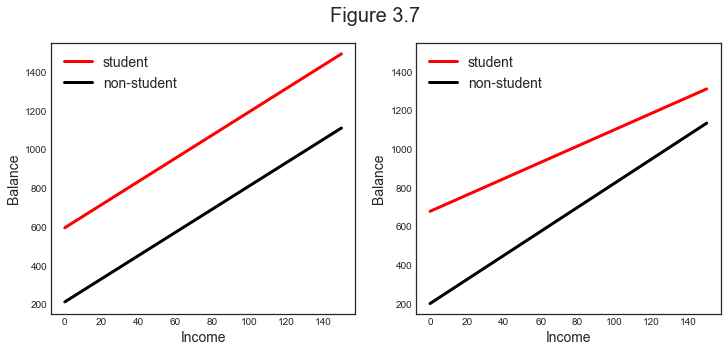

In [47]:
# Figure 3.7
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 3.7')

# Plot best fit with and without interaction
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

#### Non-linear Relationships

What if we allow for further non-linearities? Let's change dataset again and use the `car` dataset.

In [48]:
# Automobile dataset (dropping missing values)
auto = pd.read_csv('data/Auto.csv', na_values='?').dropna()

This dataset contains information of a wide variety of car models.

In [49]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Suppose we wanted to understand which car caracteristics are correlated with higher efficiency, i.e. `mpg` (miles per gallon).

Consider in particular the relationship between `mpg` and `horsepower`. It might be a highly non-linear relationship.

$$
\text{mpg} ≈ \beta_0 + \beta_1 \text{horsepower} + \beta_2 \text{horsepower}^2 + ... ???
$$

How many terms should we include?

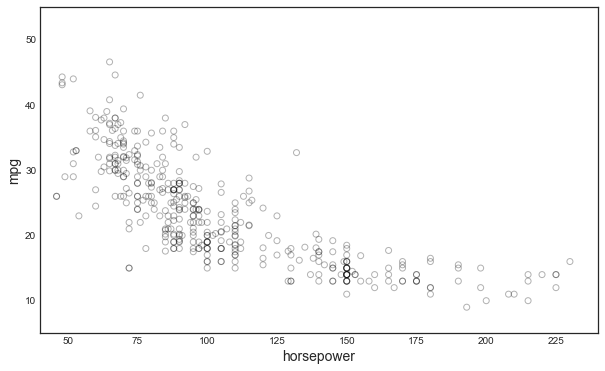

In [50]:
fig, ax = plt.subplots(1,1)

# Plot polinomials of different degree
plt.scatter(x=auto.horsepower, y=auto.mpg, facecolors='None', edgecolors='k', alpha=.3) 
plt.ylim(5,55); plt.xlim(40,240); 
plt.xlabel('horsepower'); plt.ylabel('mpg');

The relationship looks non-linear but in which way exactly? Let's try to fit polinomials of different degrees.

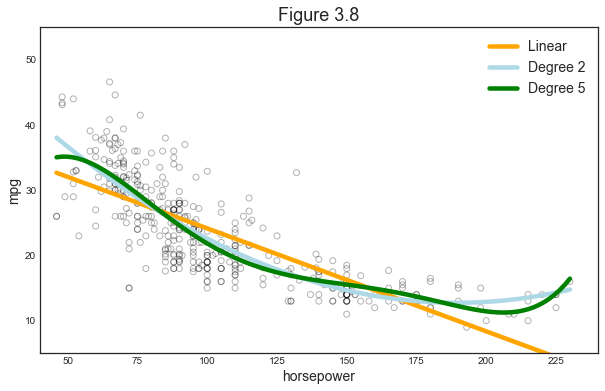

In [51]:
# Figure 3.8 
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 3.8')

# Plot polinomials of different degree
plt.scatter(x=auto.horsepower, y=auto.mpg, facecolors='None', edgecolors='k', alpha=.3) 
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

As we can see, the tails are highly unstable depending on the specification.

In [52]:
# Table 3.10
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,16900.0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,27225.0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,22500.0


In [53]:
est = sm.OLS.from_formula('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### Potential Problems

#### Non-linearities

How can we assess if there are non-linearities and of which kind? We can look at the residuals.

If the residuals show some kind of pattern, probably we could have fit the line better. Moreover, we can use the pattern itself to understand how.

In [54]:
# Figure 3.9

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr = LinearRegression().fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']]
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

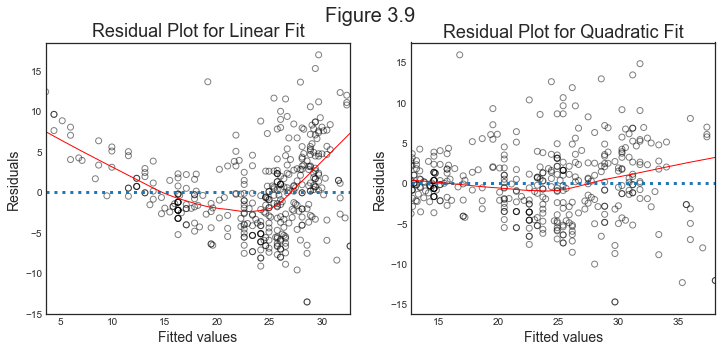

In [55]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 3.9')

# Left plot
sns.regplot(x=auto.pred1, y=auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(x=auto.pred2, y=auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

#### Outliers

Observations with high residuals have a good chance of being highly influentials. However, they do not have to be.

Let's use the following data generating process:
- $X \sim N(0,1)$
- $\varepsilon \sim N(0,0.5)$
- $\beta_0 = 3$
- $y = \beta_0 X + \varepsilon$

In [56]:
np.random.seed(1)

# Generate random y
n = 50
X = rnorm(1,1,(n,1))
e = rnorm(0,0.5,(n,1))
b0 = 3
y = X*b0 + e

Now let's change observation 7 so that it becomes an outlier, i.e. it has a high residual.

In [57]:
# Generate outlier
X[20] = 1
y[20] = 7

# Short regression without observation number 41
X_small = np.delete(X, 20)
y_small = np.delete(y, 20)

Let's now plot the data and the residuals

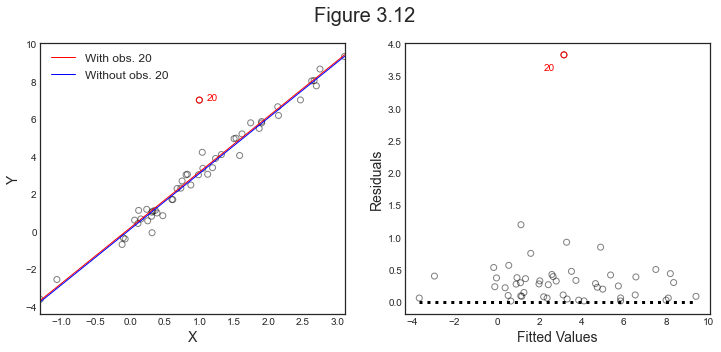

In [58]:
# Figure 3.12
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
fig.suptitle('Figure 3.12')

# Plot 1
ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); 
ax1.legend(['With obs. 20', 'Without obs. 20'], fontsize=12);

# Hihglight outliers
ax1.scatter(x=X[20], y=y[20], facecolors='None', edgecolors='r', alpha=1) 
ax1.annotate("20", (1.1, 7), color='r')

# Compute fitted values and residuals
r = regr.fit(X, y)
y_hat = r.predict(X)
e = np.abs(y - y_hat)

# Plot 2
ax2.scatter(x=y_hat, y=e, facecolors='None', edgecolors='k', alpha=.5)
ax2.set_xlabel('Fitted Values'); ax2.set_ylabel('Residuals');
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')

# Highlight outlier
ax2.scatter(x=y_hat[20], y=e[20], facecolors='None', edgecolors='r', alpha=1) 
ax2.annotate("20", (2.2, 3.6), color='r');

#### High Leverage Points

A better concept of "influential observation" is the Leverage, which represents how much an observation is distant from the others in terms of observables.

The leverage formula of observation $i$ is

$$
h_i = x_i (X' X)^{-1} x_i'
$$

However, leverage alone is not necessarily enough for an observation to being highly influential.

In [59]:
# Generate observation with high leverage
X[41] = 4
y[41] = 12

# Short regression without observation number 41
X_small = np.delete(X_small, 41)
y_small = np.delete(y_small, 41)

# Compute leverage
H = X @ inv(X.T @ X) @ X.T
h = np.diagonal(H)

# Compute fitted values and residuals
y_hat = r.predict(X)
e = np.abs(y - y_hat) 

What happens now that we have added an observation with high leverage? How does the levarage look like?

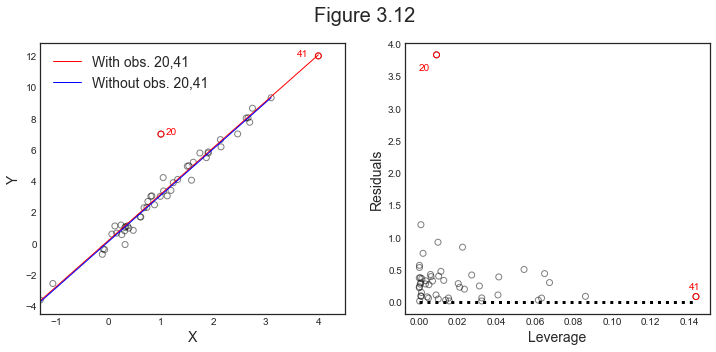

In [60]:
# Figure 3.13
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
fig.suptitle('Figure 3.12')



# Plot 1
ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
ax1.scatter(x=X[[20,41]], y=y[[20,41]], facecolors='None', edgecolors='r', alpha=1) 
sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.axis(xmax=4.5);
ax1.legend(['With obs. 20,41', 'Without obs. 20,41']);

# Highlight points
ax1.annotate("20", (1.1, 7), color='r')
ax1.annotate("41", (3.6, 12), color='r');



# Plot 2
ax2.scatter(x=h, y=e, facecolors='None', edgecolors='k', alpha=.5)
ax2.set_xlabel('Leverage'); ax2.set_ylabel('Residuals'); 
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')
# Highlight outlier
ax2.scatter(x=h[[20,41]], y=e[[20,41]], facecolors='None', edgecolors='r', alpha=1);

# Highlight points
ax2.annotate("20", (0, 3.6), color='r')
ax2.annotate("41", (0.14, 0.2), color='r');

#### Influential Observations

As we have seen, being an outliers or having high leverage alone might be not enough to conclude that an observation is influential.

What really matters is a combination of both: observations with high leverage and high residuals, i.e. observations that are not only different in terms of observables (high leverage) but are also different in terms of their relationship between observables and dependent variable (high residual).

Let's now add an observation that is both an outlier and has high leverage.

In [61]:
# Generate outlier with high leverage
X[7] = 4
y[7] = 7

# Short regression without observation number 41
X_small = np.delete(X, 7)
y_small = np.delete(y, 7)

# Compute leverage
H = X @ inv(X.T @ X) @ X.T
h = np.diagonal(H)

# Compute fitted values and residuals
r = regr.fit(X, y)
y_hat = r.predict(X)
e = np.abs(y - y_hat)

Now the best linear fit line has noticeably moved.

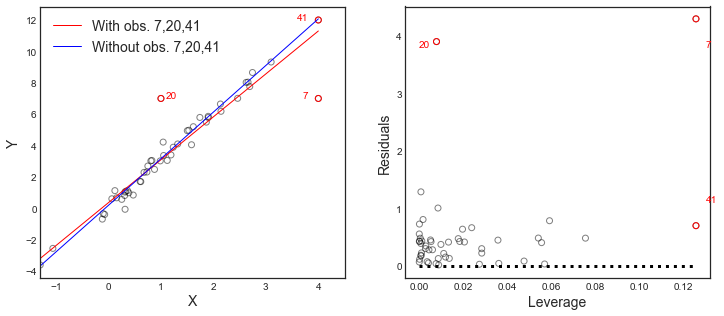

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 


# Plot 1
ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
ax1.scatter(x=X[[7,20,41]], y=y[[7,20,41]], facecolors='None', edgecolors='r', alpha=1) 
sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.axis(xmax=4.5);
ax1.legend(['With obs. 7,20,41', 'Without obs. 7,20,41']);

# Highlight points
ax1.annotate("7", (3.7, 7), color='r')
ax1.annotate("20", (1.1, 7), color='r')
ax1.annotate("41", (3.6, 12), color='r');



# Plot 2
ax2.scatter(x=h, y=e, facecolors='None', edgecolors='k', alpha=.5)
ax2.set_xlabel('Leverage'); ax2.set_ylabel('Residuals'); 
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')
# Highlight outlier
ax2.scatter(x=h[[7,20,41]], y=e[[7,20,41]], facecolors='None', edgecolors='r', alpha=1);

# Highlight points
ax2.annotate("7", (0.13, 3.8), color='r');
ax2.annotate("20", (0, 3.8), color='r')
ax2.annotate("41", (0.13, 1.1), color='r');

#### Collinearity

Collinearity is the situation in which two dependent varaibles are higly correlated with each other. Algebraically, this is a problem because the $X'X$ matrix becomes almost-non-invertible.

Let's have a look at the `ratings` dataset.

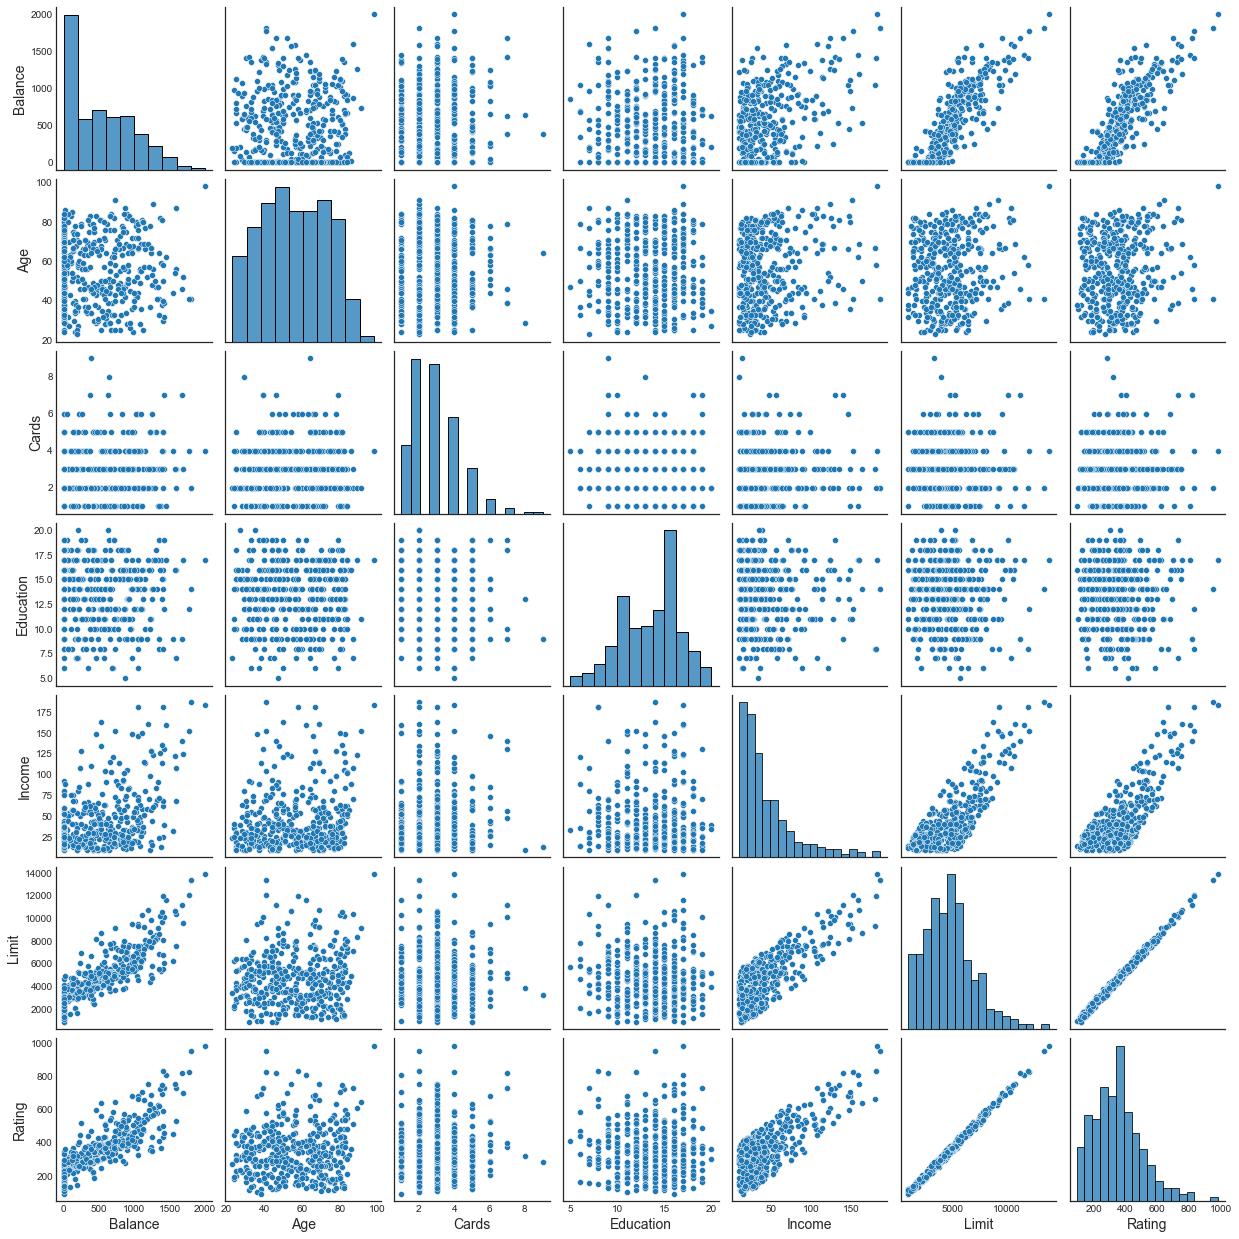

In [63]:
# Inspect dataset
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

If we zoom into the variable `Limit`, we see that for example it is not very correlated with `Age` but is very correlated with `Rating`.

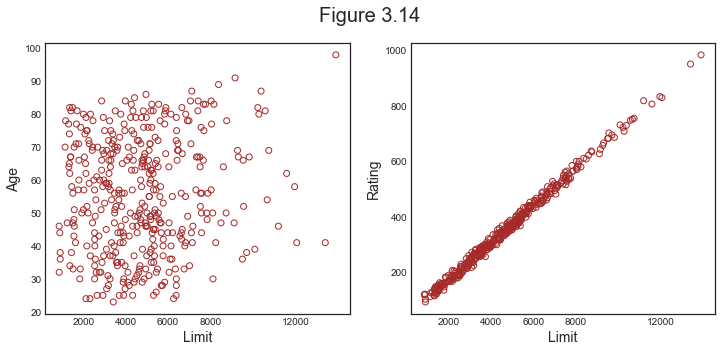

In [64]:
# Figure 3.14
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
fig.suptitle('Figure 3.14')

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='brown')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='brown')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

If we regress `Balance` on `Limit` and `Age`, the coefficient of `Limit` is positive and highly significant.

In [65]:
# Regress balance on limit and age
reg1 = sm.OLS.from_formula('Balance ~ Limit + Age', credit).fit()
reg1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-173.4109,43.828,-3.957,0.000,-259.576,-87.246
Limit,0.1734,0.005,34.496,0.000,0.163,0.183
Age,-2.2915,0.672,-3.407,0.001,-3.614,-0.969


However, if we regress `Balance` on `Limit` and `Rating`, the coefficient of `Limit` is now not significant anymore.

In [66]:
# Regress balance on limit and rating
reg2 = sm.OLS.from_formula('Balance ~ Limit + Rating', credit).fit()
reg2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-377.5368,45.254,-8.343,0.000,-466.505,-288.569
Limit,0.0245,0.064,0.384,0.701,-0.101,0.150
Rating,2.2017,0.952,2.312,0.021,0.330,4.074


Looking at the objective function, the Residual Sum of Squares, helps understanding what is the problem.

In [67]:
# First scale variables
y = credit.Balance
regr1 = LinearRegression().fit(scale(credit[['Age', 'Limit']].astype('float'), with_std=False), y)
regr2 = LinearRegression().fit(scale(credit[['Rating', 'Limit']], with_std=False), y)

# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

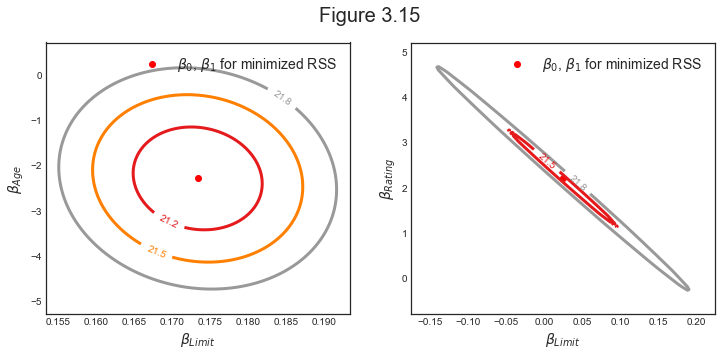

In [68]:
# Figure 3.15
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
fig.suptitle('Figure 3.15')

# Minimum
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'

# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(reg1.params[1], reg1.params[2], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$')

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(reg2.params[1], reg2.params[2], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$')
#ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$')
    ax.legend()

As we can see, in the left plot the minimum is much better defined than in the right plot.

# Labs

## Lab 1: Linear Regression

We'll start by importing the data from [Boston.csv](http://www.science.smith.edu/~jcrouser/SDS293/data/Boston.csv) into a pandas dataframe:

In [69]:
df = pd.read_csv('data/Boston.csv', index_col=0)
df.head()

,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,,,,,,,,,,,,,
0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Lab 1.1: Simple Linear Regression

Now let's fit a simple linear model (OLS - for "ordinary least squares" method) with ${\tt medv}$ as the response and ${\tt lstat}$ as the predictor:

In [70]:
lm = sm.OLS.from_formula('medv ~ lstat', df)
result = lm.fit()

To get detailed information about the model, we can print the results of a call to the ${\tt .summary()}$ method:

In [71]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           5.08e-88
Time:                        09:55:35   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Want individual attributes? You can access them independently like this:

In [72]:
result.rsquared, result.fvalue, result.params.Intercept, result.params.lstat

(0.5441462975864799, 601.6178711098955, 34.55384087938308, -0.9500493537579922)

For a complete list of attributes and methods of a ${\tt RegressionResults}$ object, see: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html?highlight=regressionresults

Now let's try making some predictions using this model. First, we'll set up a dataframe containing the ${\tt lstat}$ values for which we want to predict a response:

In [73]:
new = pd.DataFrame([[1, 5], [1, 10], [1, 15]], columns=['Intercept', 'lstat'])

Now we just call the ${\tt .predict()}$ method:

In [74]:
result.predict(new)

0    29.803594
1    25.053347
2    20.303101
dtype: float64

Technically those are the right prediction values, but maybe it would be good to have the confidence intervals along with them. Let's write a little helper function to get that and package it all up:

In [75]:
def predict(res, new):
    
    # Get the predicted values
    fit = pd.DataFrame(res.predict(new), columns=['fit'])
    
    # Get the confidence interval for the model (and rename the columns to something a bit more useful)
    ci = res.conf_int().rename(columns={0: 'lower', 1: 'upper'})
    
    # Now a little bit of matrix multiplication to get the confidence intervals for the predictions
    ci = ci.T.dot(new.T).T
    
    # And finally wrap up the confidence intervals with the predicted values
    return pd.concat([fit, ci], axis=1)

In [76]:
predict(result, new)

,fit,lower,upper
0,29.803594,28.317716,31.289472
1,25.053347,23.186975,26.919720
2,20.303101,18.056234,22.549967


We will now plot ${\tt medv}$ and ${\tt lstat}$ along with the least squares regression line using the ${\tt regplot()}$ function. We can define the color of the fit line using ${\tt line\_kws}$ ("line keywords"):

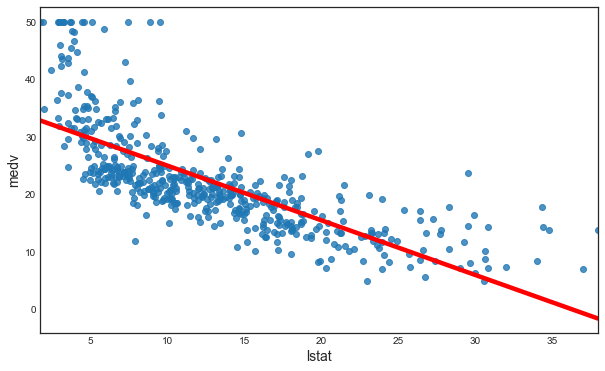

In [77]:
sns.regplot(x='lstat', y='medv', data=df, line_kws = {"color":"r"}, ci=None);

We can also plot the residuals against the fitted values:

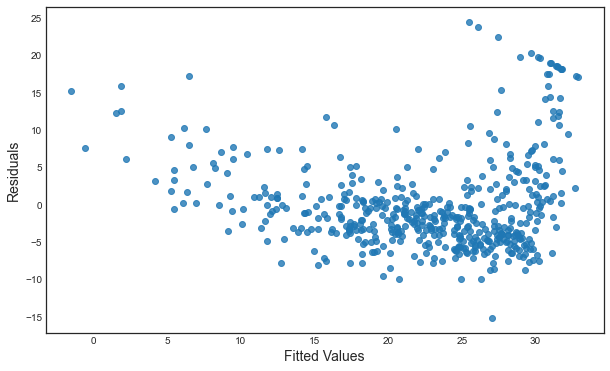

In [78]:
fitted_values = pd.Series(result.fittedvalues, name="Fitted Values")
residuals = pd.Series(result.resid, name="Residuals")
sns.regplot(x=fitted_values, y=residuals, fit_reg=False);

Perhaps we want normalized residuals instead?

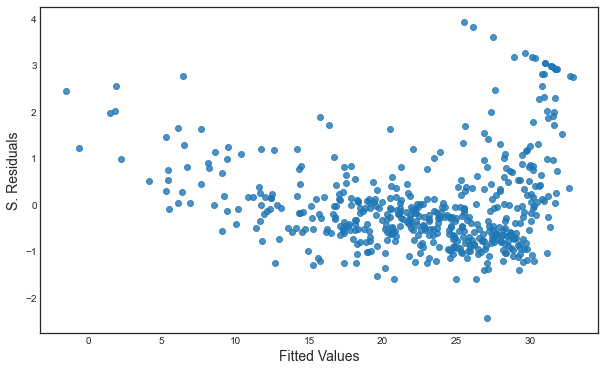

In [79]:
s_residuals = pd.Series(result.resid_pearson, name="S. Residuals")
sns.regplot(x=fitted_values, y=s_residuals,  fit_reg=False);

We can also look for points with high leverage:

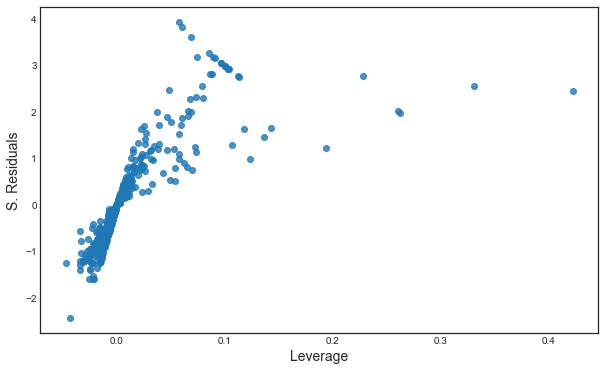

In [80]:
leverage = pd.Series(OLSInfluence(result).influence, name = "Leverage")
sns.regplot(x=leverage, y=s_residuals,  fit_reg=False);

###  Lab 1.2: Multiple Linear Regression

In order to fit a multiple linear regression model using least squares, we again use the ${\tt from\_formula()}$ function. The syntax ${\tt from\_formula(y∼x1+x2+x3)}$ is used to fit a model with three predictors, $x1$, $x2$, and $x3$. The ${\tt summary()}$ function now outputs the regression coefficients for all the predictors.

In [81]:
model = sm.OLS.from_formula('medv ~ lstat + age', df)
result = model.fit()

# Print
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           2.98e-88
Time:                        09:55:37   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.000      31.787      34.659
lstat         -1.0321      0.048    -21.416      0.000      -1.127      -0.937
age            0.0345      0.012      2.826      0.005       0.011       0.059
==============================================================================
Omnibus:                      124.288   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.026
Skew:                           1.362   Prob(JB):                     1.02e-53
Kurtosis:                       5.038   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The Boston data set contains 13 variables, and so it would be cumbersome to have to type all of these in order to perform a regression using all of the predictors. Instead, we can use the following short-hand:

In [82]:
# All columns (except medv, which is our response)
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv'])), df)
result = model.fit()

# Print
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.9
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          1.23e-133
Time:                        09:55:37   Log-Likelihood:                -1504.3
No. Observations:                 506   AIC:                             3035.
Df Residuals:                     493   BIC:                             3090.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.3797      5.143      6.879      0.000      25.274      45.485
age            0.0005      0.013      0.041      0.967      -0.026       0.027
black          0.0103      0.003      3.841      0.000       0.005       0.016
chas           2.8284      0.869      3.255      0.001       1.121       4.536
dis           -1.3990      0.200     -6.993      0.000      -1.792      -1.006
indus          0.0281      0.062      0.452      0.651      -0.094       0.150
lstat         -0.5502      0.051    -10.870      0.000      -0.650      -0.451
nox          -17.0182      3.851     -4.420      0.000     -24.584      -9.452
ptratio       -0.9437      0.132     -7.145      0.000      -1.203      -0.684
rad            0.2478      0.065      3.838      0.000       0.121       0.375
rm             3.8460      0.422      9.116      0.000       3.017       4.675
tax           -0.0122      0.004     -3.210      0.001      -0.020      -0.005
zn             0.0425      0.014      3.077      0.002       0.015       0.070
==============================================================================
Omnibus:                      171.086   Durbin-Watson:                   1.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.307
Skew:                           1.449   Prob(JB):                    4.83e-166
Kurtosis:                       8.264   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that we used the syntax ${\tt .join(df.columns.difference(['medv']))}$ to exclude the response variable above. We can use the same napproach to perform a regression using just a subset of the predictors? For example, in the above regression output, ${\tt age}$ and ${\tt indus}$ have a high p-value. So we may wish to run a regression excluding these predictors:

In [83]:
# All columns (except medv)
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv', 'age', 'indus'])), df)
result = model.fit()

# Print
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     137.2
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          9.95e-136
Time:                        09:55:37   Log-Likelihood:                -1504.4
No. Observations:                 506   AIC:                             3031.
Df Residuals:                     495   BIC:                             3077.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.2255      5.107      6.898      0.000      25.192      45.259
black          0.0103      0.003      3.847      0.000       0.005       0.016
chas           2.8715      0.862      3.333      0.001       1.179       4.564
dis           -1.4203      0.186     -7.625      0.000      -1.786      -1.054
lstat         -0.5479      0.047    -11.590      0.000      -0.641      -0.455
nox          -16.5113      3.561     -4.637      0.000     -23.507      -9.515
ptratio       -0.9355      0.130     -7.179      0.000      -1.192      -0.679
rad            0.2389      0.061      3.898      0.000       0.118       0.359
rm             3.8323      0.410      9.341      0.000       3.026       4.638
tax           -0.0114      0.003     -3.357      0.001      -0.018      -0.005
zn             0.0417      0.014      3.069      0.002       0.015       0.068
==============================================================================
Omnibus:                      171.393   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              765.246
Skew:                           1.451   Prob(JB):                    6.74e-167
Kurtosis:                       8.280   Cond. No.                     1.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Lab 1.3: Interaction Terms

It is easy to include interaction terms in a linear model using the ${\tt .from\_formula()}$ function. The syntax ${\tt lstat:black}$ tells Python to include an interaction term between ${\tt lstat}$ and ${\tt black}$. The syntax ${\tt lstat*age}$ simultaneously includes ${\tt lstat}$, ${\tt age}$, and the interaction term ${\tt lstat×age}$ as predictors; it is a shorthand for ${\tt lstat+age+lstat:age}$.

In [84]:
sm.OLS.from_formula('medv ~ lstat*age', df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           4.86e-88
Time:                        09:55:37   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.000      33.201      38.976
lstat         -1.3921      0.167     -8.313      0.000      -1.721      -1.063
age           -0.0007      0.020     -0.036      0.971      -0.040       0.038
lstat:age      0.0042      0.002      2.244      0.025       0.001       0.008
==============================================================================
Omnibus:                      135.601   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.955
Skew:                           1.417   Prob(JB):                     3.29e-65
Kurtosis:                       5.461   Cond. No.                     6.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Lab 1.4: Non-linear Transformations of the Predictors

The ${\tt .from\_formula()}$ function can also accommodate non-linear transformations of the predictors. For instance, given a predictor ${\tt X}$, we can create a predictor ${\tt X^\wedge2}$ using ${\tt np.square(X)}$. We now perform a regression of ${\tt medv}$ onto ${\tt lstat}$ and ${\tt lstat^\wedge 2}$.

In [85]:
lm.fit2 = sm.OLS.from_formula('medv ~ lstat + np.square(lstat)', df).fit()

# Print
lm.fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          1.56e-112
Time:                        09:55:37   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           42.8620      0.872     49.149      0.000      41.149      44.575
lstat               -2.3328      0.124    -18.843      0.000      -2.576      -2.090
np.square(lstat)     0.0435      0.004     11.628      0.000       0.036       0.051
==============================================================================
Omnibus:                      107.006   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.388
Skew:                           1.128   Prob(JB):                     2.55e-50
Kurtosis:                       5.397   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The near-zero p-value associated with the quadratic term suggests that it leads to an improved model. We use the ${\tt anova\_lm()}$ function to further quantify the extent to which the quadratic fit is superior to the linear fit.

In [86]:
lm.fit = sm.OLS.from_formula('medv ~ lstat', df).fit()

# Print
sm.stats.anova_lm(lm.fit, lm.fit2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,19472.381418,0.0,NaN,NaN,NaN
1,503.0,15347.243158,1.0,4125.13826,135.199822,7.630116e-28


Here Model 0 represents the linear submodel containing only one predictor, ${\tt lstat}$, while Model 1 corresponds to the larger quadraticmodel that has two predictors, ${\tt lstat}$ and ${\tt lstat2}$. The ${\tt anova\_lm()}$ function performs a hypothesis test comparing the two models. The null hypothesis is that the two models fit the data equally well, and the alternative hypothesis is that the full model is superior. 

The F-statistic is 135 and the associated p-value is virtually zero. This provides very clear evidence that the model containing the predictors ${\tt lstat}$ and ${\tt lstat2}$ is far superior to the model that only contains the predictor ${\tt lstat}$. This is not surprising, since earlier we saw evidence for non-linearity in the relationship between ${\tt medv}$ and ${\tt lstat}$. 

If we type:

In [87]:
fitted_values = pd.Series(lm.fit2.fittedvalues, name="Fitted Values")
residuals = pd.Series(lm.fit2.resid, name="S. Residuals")

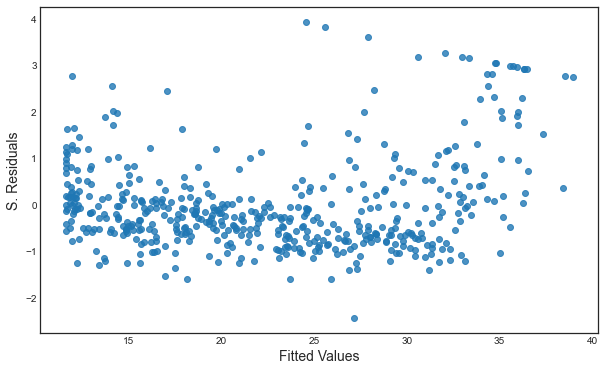

In [88]:
sns.regplot(x=fitted_values, y=s_residuals,  fit_reg=False);

then we see that when the ${\tt lstat2}$ term is included in the model, there is little discernible pattern in the residuals.

In order to create a cubic fit, we can include a predictor of the form ${\tt np.power(x, 3))}$. However, this approach can start to get cumbersome for higher order polynomials. A better approach involves using list comprehension inside a ${\tt .join()}$. For example, the following command produces a fifth-order polynomial fit:

In [89]:
formula = 'medv ~ ' + '+'.join(['np.power(lstat,' + str(i) + ')' for i in range(1,6)])
sm.OLS.from_formula(formula, df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          8.73e-122
Time:                        09:55:37   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             67.6997      3.604     18.783      0.000      60.618      74.781
np.power(lstat, 1)   -11.9911      1.526     -7.859      0.000     -14.989      -8.994
np.power(lstat, 2)     1.2728      0.223      5.703      0.000       0.834       1.711
np.power(lstat, 3)    -0.0683      0.014     -4.747      0.000      -0.097      -0.040
np.power(lstat, 4)     0.0017      0.000      4.143      0.000       0.001       0.003
np.power(lstat, 5) -1.632e-05   4.42e-06     -3.692      0.000    -2.5e-05   -7.63e-06
==============================================================================
Omnibus:                      144.085   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.545
Skew:                           1.292   Prob(JB):                    4.08e-108
Kurtosis:                       7.096   Cond. No.                     1.37e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Of course, we are in no way restricted to using polynomial transformations of the predictors. Here we try a log transformation.

In [90]:
sm.OLS.from_formula('medv ~ np.log(rm)', df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     389.3
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           1.22e-64
Time:                        09:55:37   Log-Likelihood:                -1695.4
No. Observations:                 506   AIC:                             3395.
Df Residuals:                     504   BIC:                             3403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.4878      5.028    -15.213      0.000     -86.366     -66.610
np.log(rm)    54.0546      2.739     19.732      0.000      48.672      59.437
==============================================================================
Omnibus:                      117.102   Durbin-Watson:                   0.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              584.336
Skew:                           0.916   Prob(JB):                    1.30e-127
Kurtosis:                       7.936   Cond. No.                         38.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Lab 1.5: Qualitative Predictors

We will now examine the [${\tt Carseats}$](http://www.science.smith.edu/~jcrouser/SDS293/data/Carseats.csv) data that we talked about earlier in class. We will attempt to predict ${\tt Sales}$ (child car seat sales) in 400 locations based on a number of predictors.

In [91]:
df2 = pd.read_csv('data/Carseats.csv')
df2.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


The ${\tt Carseats}$ data includes qualitative predictors such as ${\tt Shelveloc}$, an indicator of the quality of the shelving location—that is, the space within a store in which the car seat is displayed—at each location. The predictor ${\tt Shelveloc}$ takes on three possible values, ${\tt Bad}$, ${\tt Medium}$, and ${\tt Good}$.

Given a qualitative variable such as ${\tt Shelveloc}$, Python generates dummy variables automatically. Below we fit a multiple regression model that includes some interaction terms.

In [92]:
sm.OLS.from_formula('Sales ~ Income:Advertising + Price:Age + ' + "+".join(df2.columns.difference(['Sales'])), df2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          6.14e-166
Time:                        09:55:37   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.5756      1.009      6.519      0.000       4.592       8.559
ShelveLoc[T.Good]       4.8487      0.153     31.724      0.000       4.548       5.149
ShelveLoc[T.Medium]     1.9533      0.126     15.531      0.000       1.706       2.201
US[T.Yes]              -0.1576      0.149     -1.058      0.291      -0.450       0.135
Urban[T.Yes]            0.1402      0.112      1.247      0.213      -0.081       0.361
Income:Advertising      0.0008      0.000      2.698      0.007       0.000       0.001
Price:Age               0.0001      0.000      0.801      0.424      -0.000       0.000
Advertising             0.0702      0.023      3.107      0.002       0.026       0.115
Age                    -0.0579      0.016     -3.633      0.000      -0.089      -0.027
CompPrice               0.0929      0.004     22.567      0.000       0.085       0.101
Education              -0.0209      0.020     -1.063      0.288      -0.059       0.018
Income                  0.0109      0.003      4.183      0.000       0.006       0.016
Population              0.0002      0.000      0.433      0.665      -0.001       0.001
Price                  -0.1008      0.007    -13.549      0.000      -0.115      -0.086
==============================================================================
Omnibus:                        1.281   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.147
Skew:                           0.129   Prob(JB):                        0.564
Kurtosis:                       3.050   Cond. No.                     1.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To learn how to set other coding schemes (or _contrasts_), see: http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/contrasts.html

## Next Session

Jump to [Session 2 - Instrumental Variables](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/2_iv.ipynb)